In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using device: {device}')

Using device: mps


In [2]:
from AE import ConvAE, train_AE
from diffusion import DiffusionNet, train_diffusion, sample, compute_latent_stats

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=transform
)

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True,
                              num_workers=8, persistent_workers=True)

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

/Users/andreichernov/Documents/Personal/education/diffusion/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


In [6]:
train_dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

In [7]:
# hyperparameters
latent_channels = 64  # token_dim — must match DiffusionNet hidden_size
T = 100  # diffusion timesteps
n_layers = 4  # transformer layers
n_heads = 4  # attention heads (64 / 4 = 16 per head)
mlp_size = 256  # FFN intermediate size
dropout_rate = 0.05
lr_ae = 1e-3
lr_diff = 5e-4
ae_epochs = 20
diff_epochs = 100

In [8]:
model_AE = ConvAE(latent_channels=latent_channels)
print(f"ConvAE: {model_AE.n_tokens} tokens x {model_AE.token_dim} dim")

ConvAE: 49 tokens x 64 dim


In [9]:
train_AE(model_AE, ae_epochs, train_dataloader, lr=lr_ae, device=device)

epoch 1/20 done - avg loss=0.5253
epoch 2/20 done - avg loss=0.1587
epoch 3/20 done - avg loss=0.1006
epoch 4/20 done - avg loss=0.0838
epoch 5/20 done - avg loss=0.0772
epoch 6/20 done - avg loss=0.0732
epoch 7/20 done - avg loss=0.0706
epoch 8/20 done - avg loss=0.0689
epoch 9/20 done - avg loss=0.0677
epoch 10/20 done - avg loss=0.0667
epoch 11/20 done - avg loss=0.0660
epoch 12/20 done - avg loss=0.0654
epoch 13/20 done - avg loss=0.0650
epoch 14/20 done - avg loss=0.0646
epoch 15/20 done - avg loss=0.0643
epoch 16/20 done - avg loss=0.0641
epoch 17/20 done - avg loss=0.0639
epoch 18/20 done - avg loss=0.0637
epoch 19/20 done - avg loss=0.0636
epoch 20/20 done - avg loss=0.0634


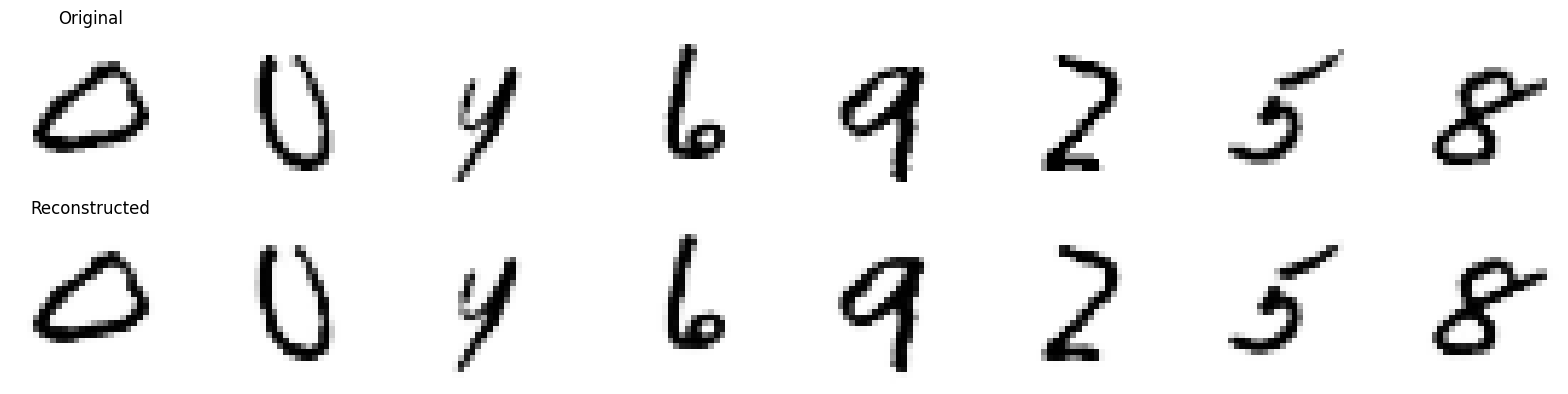

In [10]:
# visualize AE reconstructions
model_AE.eval()
with torch.no_grad():
    x_sample, _ = next(iter(train_dataloader))
x_sample = x_sample[:8].to(device)
recon, _ = model_AE(x_sample)
recon = torch.sigmoid(recon)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(x_sample[i, 0].cpu(), cmap='Greys')
axes[0, i].axis('off')
axes[1, i].imshow(recon[i, 0].cpu(), cmap='Greys')
axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed')
plt.tight_layout()

In [ ]:
# compute latent stats for normalization
latent_mean, latent_std = compute_latent_stats(model_AE, train_dataloader, device)
print(f"Latent mean range: [{latent_mean.min():.3f}, {latent_mean.max():.3f}]")
print(f"Latent std range:  [{latent_std.min():.3f}, {latent_std.max():.3f}]")

In [11]:
diff_model = DiffusionNet(
    hidden_size=latent_channels,  # must match AE token_dim = 64
    n_layers=n_layers,
    n_heads=n_heads,
    dropout_rate=dropout_rate,
    mlp_size=mlp_size,
    T=T,
)

In [ ]:
train_diffusion(diff_model, model_AE, diff_epochs, train_dataloader, T, lr=lr_diff,
                latent_mean=latent_mean, latent_std=latent_std, device=device)

In [ ]:
generated = sample(
    diff_model, model_AE,
    n_samples=16, T=T,
    n_tokens=model_AE.n_tokens,
    token_dim=model_AE.token_dim,
    latent_mean=latent_mean,
    latent_std=latent_std,
    device=device,
)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    axes[i // 8, i % 8].imshow(generated[i, 0].cpu(), cmap='Greys')
    axes[i // 8, i % 8].axis('off')
plt.suptitle('Generated MNIST Digits')
plt.tight_layout()